In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import requests
import zipfile
from tqdm import tqdm
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [2]:
from pathlib import Path

base_dir = Path('../../dataset/baby')   
train_dir = base_dir / 'training_set'
test_dir = base_dir / 'test_set'

print("Training set path:", train_dir.resolve())
print("Test set path:", test_dir.resolve())

train_files = list(train_dir.glob('*'))
test_files = list(test_dir.glob('*'))

print(f"Found {len(train_files)} training files")
print(f"Found {len(test_files)} test files")

Training set path: C:\Users\quang\ipynb code\mlmed\dataset\baby\training_set
Test set path: C:\Users\quang\ipynb code\mlmed\dataset\baby\test_set
Found 1998 training files
Found 335 test files


In [3]:
train_images = sorted(list(train_dir.glob('*.png')))
test_images = sorted(list(test_dir.glob('*.png')))

print(f'Training images: {len([f for f in train_images if "Annotation" not in f.name])}')
print(f'Training annotations: {len([f for f in train_images if "Annotation" in f.name])}')
print(f'Test images: {len(test_images)}')

Training images: 999
Training annotations: 999
Test images: 335


In [4]:
class HC18Dataset(Dataset):
    def __init__(self, image_dir, transform=None, is_train=True):
        self.image_dir = Path(image_dir)
        self.transform = transform
        self.is_train = is_train
        
        all_files = sorted(list(self.image_dir.glob('*.png')))
        self.image_files = [f for f in all_files if 'Annotation' not in f.name]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        
        if self.is_train:
            anno_path = img_path.parent / f"{img_path.stem}_Annotation.png"
            mask = cv2.imread(str(anno_path), cv2.IMREAD_GRAYSCALE)
            image = image.astype(np.float32) / 255.0
            mask = mask.astype(np.float32) / 255.0

            image = torch.from_numpy(image).unsqueeze(0)  
            mask = torch.from_numpy(mask).unsqueeze(0)
            
            if self.transform:
                seed = np.random.randint(2147483647)
                torch.manual_seed(seed)
                image = self.transform(image)
                torch.manual_seed(seed)
                mask = self.transform(mask)
            
            return image, mask
        else:
            image = image.astype(np.float32) / 255.0
            image = torch.from_numpy(image).unsqueeze(0)
            
            if self.transform:
                image = self.transform(image)
            
            return image, str(img_path.name)

In [5]:
from torch.utils.data import random_split

full_train_dataset = HC18Dataset(train_dir, is_train=True)

total_size = len(full_train_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_train_dataset, 
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f'Train size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')
print(f'Test size: {len(test_dataset)}')

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f'\nNumber of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}')

Train size: 799
Validation size: 99
Test size: 101

Number of batches - Train: 799, Val: 99, Test: 101


In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)


class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1, features=[16, 32, 64, 128]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        for feature in features:
            self.encoder.append(DoubleConv(in_channels, feature))
            in_channels = feature
        
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        
        for feature in reversed(features):
            self.decoder.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConv(feature*2, feature))
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
    
    def forward(self, x):
        skip_connections = []
        
        for encode in self.encoder:
            x = encode(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        
        for idx in range(0, len(self.decoder), 2):
            x = self.decoder[idx](x)
            skip_connection = skip_connections[idx//2]
            
            if x.shape != skip_connection.shape:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:])
            
            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder[idx+1](x)
        
        return torch.sigmoid(self.final_conv(x))


model = UNet().to(device)
print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

x = torch.randn(1, 1, 256, 256).to(device)
output = model(x)
print(f'Input shape: {x.shape}')
print(f'Output shape: {output.shape}')

Model parameters: 1,943,761
Input shape: torch.Size([1, 1, 256, 256])
Output shape: torch.Size([1, 1, 256, 256])


In [7]:
loss_functions = {
    'MSE': nn.MSELoss(),
    'BCE': nn.BCELoss(),
}

print('Loss functions defined:')
for name in loss_functions.keys():
    print(f'  - {name}')

Loss functions defined:
  - MSE
  - BCE


In [8]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for images, masks in tqdm(loader, desc='Training'):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
    
    return total_loss / len(loader)

def calculate_metrics(pred, target):
    """Calculate MAE and IoU"""
    mae = torch.abs(pred - target).mean().item()
    
    intersection = (pred * target).sum().item()
    union = pred.sum().item() + target.sum().item() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    
    return mae, iou

In [9]:
num_epochs = 20
learning_rate = 0.001

results = {}
models_dict = {}
history = {}

for loss_name, criterion in loss_functions.items():
    print(f'\n{"="*60}')
    print(f'Training with {loss_name} loss function')
    print(f'{"="*60}')
    
    model = UNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    models_dict[loss_name] = model
    history[loss_name] = {
        'train_loss': train_losses,
        'val_loss': val_losses
    }
    
    torch.save(model.state_dict(), f'model_{loss_name.replace("+", "_")}.pth')
    print(f'\nModel saved: model_{loss_name.replace("+", "_")}.pth')

print('\n' + '='*60)
print('All models trained successfully!')
print('='*60)


Training with MSE loss function

Epoch 1/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.74it/s]


Train Loss: 0.0240, Val Loss: 0.0077

Epoch 2/20


Training: 100%|██████████| 799/799 [00:52<00:00, 15.27it/s]


Train Loss: 0.0073, Val Loss: 0.0070

Epoch 3/20


Training: 100%|██████████| 799/799 [00:51<00:00, 15.37it/s]


Train Loss: 0.0069, Val Loss: 0.0068

Epoch 4/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.75it/s]


Train Loss: 0.0067, Val Loss: 0.0067

Epoch 5/20


Training: 100%|██████████| 799/799 [00:51<00:00, 15.64it/s]


Train Loss: 0.0067, Val Loss: 0.0067

Epoch 6/20


Training: 100%|██████████| 799/799 [00:52<00:00, 15.32it/s]


Train Loss: 0.0066, Val Loss: 0.0067

Epoch 7/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.93it/s]


Train Loss: 0.0066, Val Loss: 0.0066

Epoch 8/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.79it/s]


Train Loss: 0.0066, Val Loss: 0.0066

Epoch 9/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.72it/s]


Train Loss: 0.0065, Val Loss: 0.0067

Epoch 10/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.84it/s]


Train Loss: 0.0065, Val Loss: 0.0067

Epoch 11/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.82it/s]


Train Loss: 0.0065, Val Loss: 0.0066

Epoch 12/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.74it/s]


Train Loss: 0.0065, Val Loss: 0.0066

Epoch 13/20


Training: 100%|██████████| 799/799 [00:51<00:00, 15.59it/s]


Train Loss: 0.0064, Val Loss: 0.0066

Epoch 14/20


Training: 100%|██████████| 799/799 [00:52<00:00, 15.33it/s]


Train Loss: 0.0064, Val Loss: 0.0066

Epoch 15/20


Training: 100%|██████████| 799/799 [00:52<00:00, 15.36it/s]


Train Loss: 0.0064, Val Loss: 0.0066

Epoch 16/20


Training: 100%|██████████| 799/799 [00:52<00:00, 15.17it/s]


Train Loss: 0.0063, Val Loss: 0.0067

Epoch 17/20


Training: 100%|██████████| 799/799 [00:51<00:00, 15.55it/s]


Train Loss: 0.0062, Val Loss: 0.0066

Epoch 18/20


Training: 100%|██████████| 799/799 [00:51<00:00, 15.40it/s]


Train Loss: 0.0062, Val Loss: 0.0067

Epoch 19/20


Training: 100%|██████████| 799/799 [00:53<00:00, 14.81it/s]


Train Loss: 0.0061, Val Loss: 0.0067

Epoch 20/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.71it/s]


Train Loss: 0.0060, Val Loss: 0.0068

Model saved: model_MSE.pth

Training with BCE loss function

Epoch 1/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.77it/s]


Train Loss: 0.1254, Val Loss: 0.0384

Epoch 2/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.80it/s]


Train Loss: 0.0331, Val Loss: 0.0302

Epoch 3/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.87it/s]


Train Loss: 0.0286, Val Loss: 0.0285

Epoch 4/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.03it/s]


Train Loss: 0.0271, Val Loss: 0.0275

Epoch 5/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.14it/s]


Train Loss: 0.0263, Val Loss: 0.0279

Epoch 6/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.02it/s]


Train Loss: 0.0257, Val Loss: 0.0272

Epoch 7/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.84it/s]


Train Loss: 0.0252, Val Loss: 0.0266

Epoch 8/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.89it/s]


Train Loss: 0.0248, Val Loss: 0.0265

Epoch 9/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.02it/s]


Train Loss: 0.0245, Val Loss: 0.0275

Epoch 10/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.13it/s]


Train Loss: 0.0242, Val Loss: 0.0260

Epoch 11/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.09it/s]


Train Loss: 0.0239, Val Loss: 0.0266

Epoch 12/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.98it/s]


Train Loss: 0.0236, Val Loss: 0.0264

Epoch 13/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.82it/s]


Train Loss: 0.0232, Val Loss: 0.0280

Epoch 14/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.92it/s]


Train Loss: 0.0230, Val Loss: 0.0280

Epoch 15/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.04it/s]


Train Loss: 0.0226, Val Loss: 0.0276

Epoch 16/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.13it/s]


Train Loss: 0.0223, Val Loss: 0.0283

Epoch 17/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.14it/s]


Train Loss: 0.0218, Val Loss: 0.0294

Epoch 18/20


Training: 100%|██████████| 799/799 [00:50<00:00, 15.98it/s]


Train Loss: 0.0215, Val Loss: 0.0297

Epoch 19/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.00it/s]


Train Loss: 0.0211, Val Loss: 0.0305

Epoch 20/20


Training: 100%|██████████| 799/799 [00:49<00:00, 16.08it/s]


Train Loss: 0.0205, Val Loss: 0.0329

Model saved: model_BCE.pth

All models trained successfully!


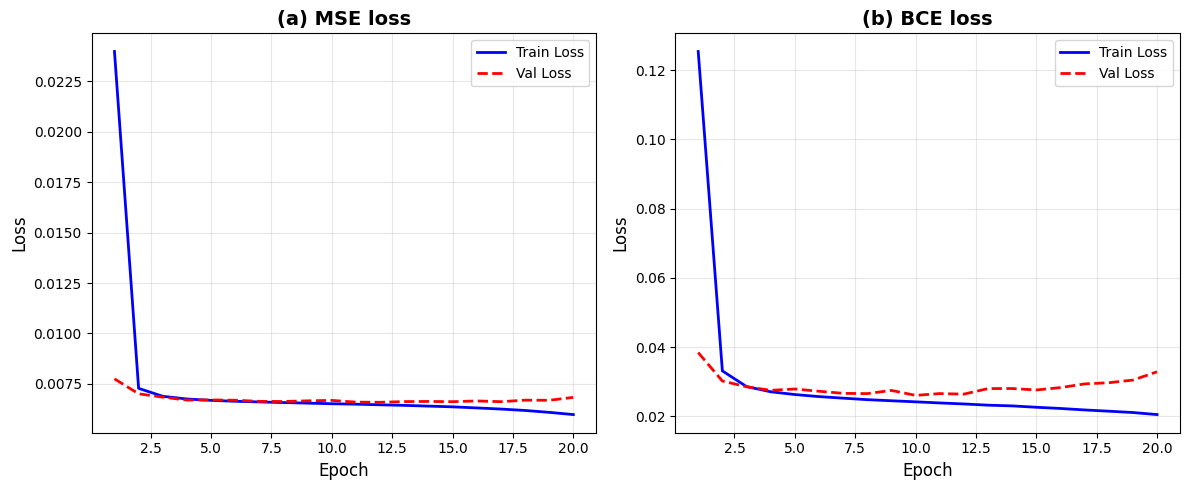

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

loss_names = ['MSE', 'BCE']
titles = ['(a) MSE loss', '(b) BCE loss']

for idx, (loss_name, title) in enumerate(zip(loss_names, titles)):
    ax = axes[idx]
    hist = history[loss_name]
    
    epochs_range = range(1, num_epochs + 1)
    ax.plot(epochs_range, hist['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax.plot(epochs_range, hist['val_loss'], 'r--', label='Val Loss', linewidth=2)
    
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Loss', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('table1_loss_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
test_results = {}

for loss_name, model in models_dict.items():
    model.eval()
    total_mae = 0
    total_iou = 0
    count = 0
    
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            
            mae, iou = calculate_metrics(outputs, masks)
            total_mae += mae
            total_iou += iou
            count += 1
    
    avg_mae = total_mae / count
    avg_iou = total_iou / count
    
    test_results[loss_name] = {
        'MAE': avg_mae,
        'IoU': avg_iou
    }
    
    print(f'{loss_name} - MAE: {avg_mae:.4f}, IoU: {avg_iou:.4f}')

print('\n' + '='*50)
print('Table 2: MAE and IoU values for test dataset')
print('='*50)
print(f'{"Loss function":<15} {"MAE":<12} {"IoU":<12}')
print('-'*50)
for loss_name, metrics in test_results.items():
    print(f'{loss_name:<15} {metrics["MAE"]:<12.4f} {metrics["IoU"]:<12.4f}')
print('='*50)

df_results = pd.DataFrame(test_results).T
df_results.to_csv('table2_test_results.csv')

MSE - MAE: 0.0124, IoU: 0.0662
BCE - MAE: 0.0114, IoU: 0.0644

Table 2: MAE and IoU values for test dataset
Loss function   MAE          IoU         
--------------------------------------------------
MSE             0.0124       0.0662      
BCE             0.0114       0.0644      



Generating Figure 2...


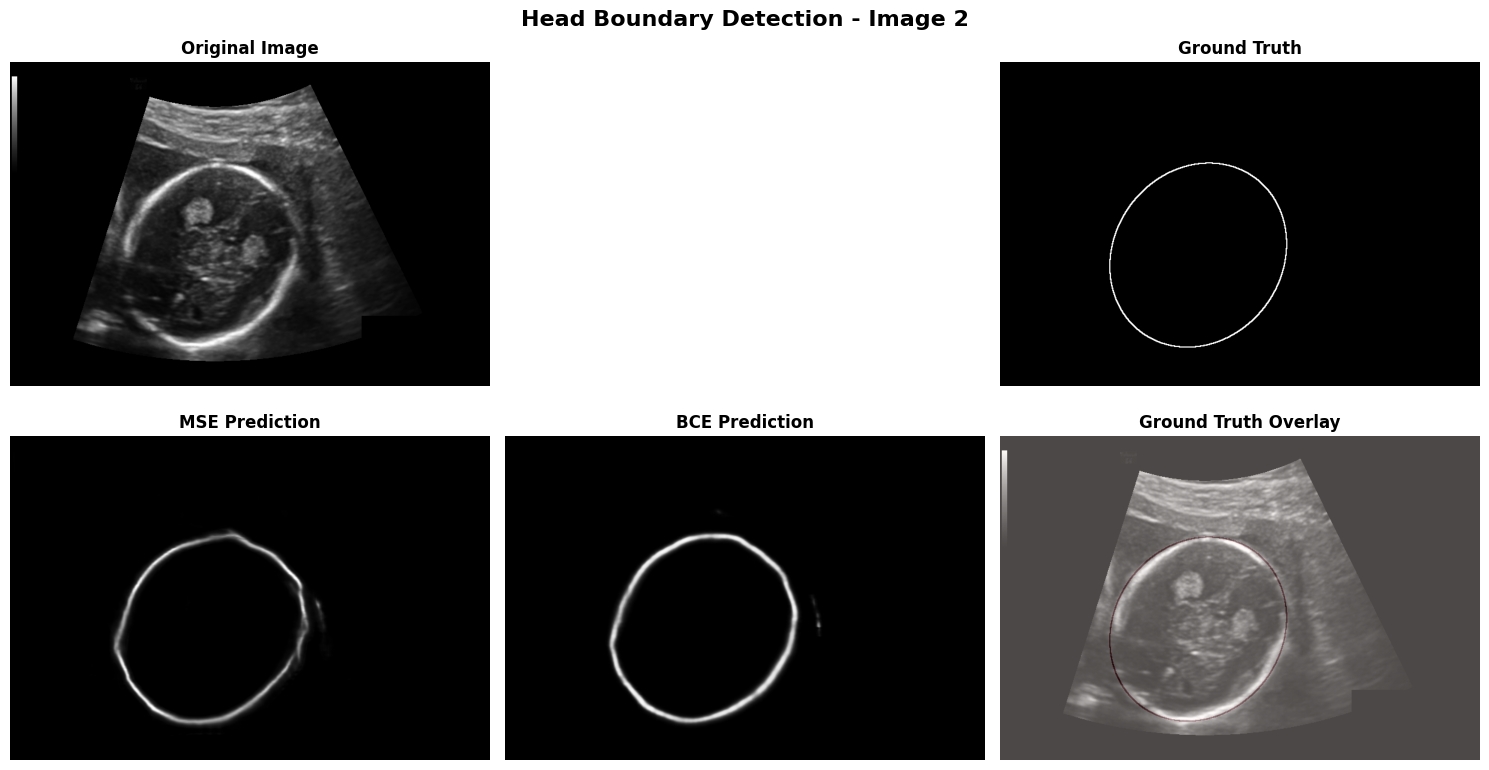

**Figure saved: figure2_head_boundary.png**

Generating Figure 51...


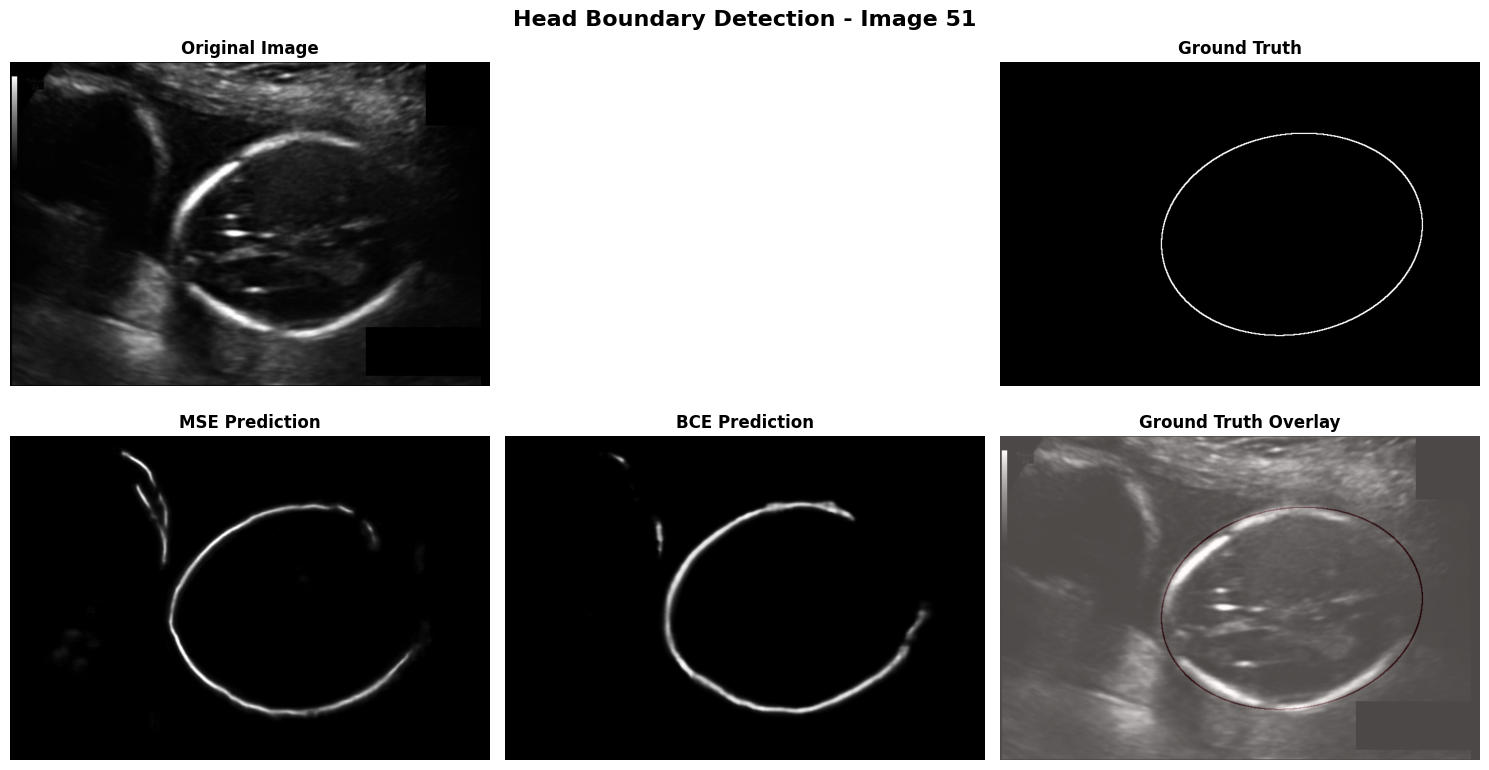

**Figure saved: figure51_head_boundary.png**

Generating Figure 91...


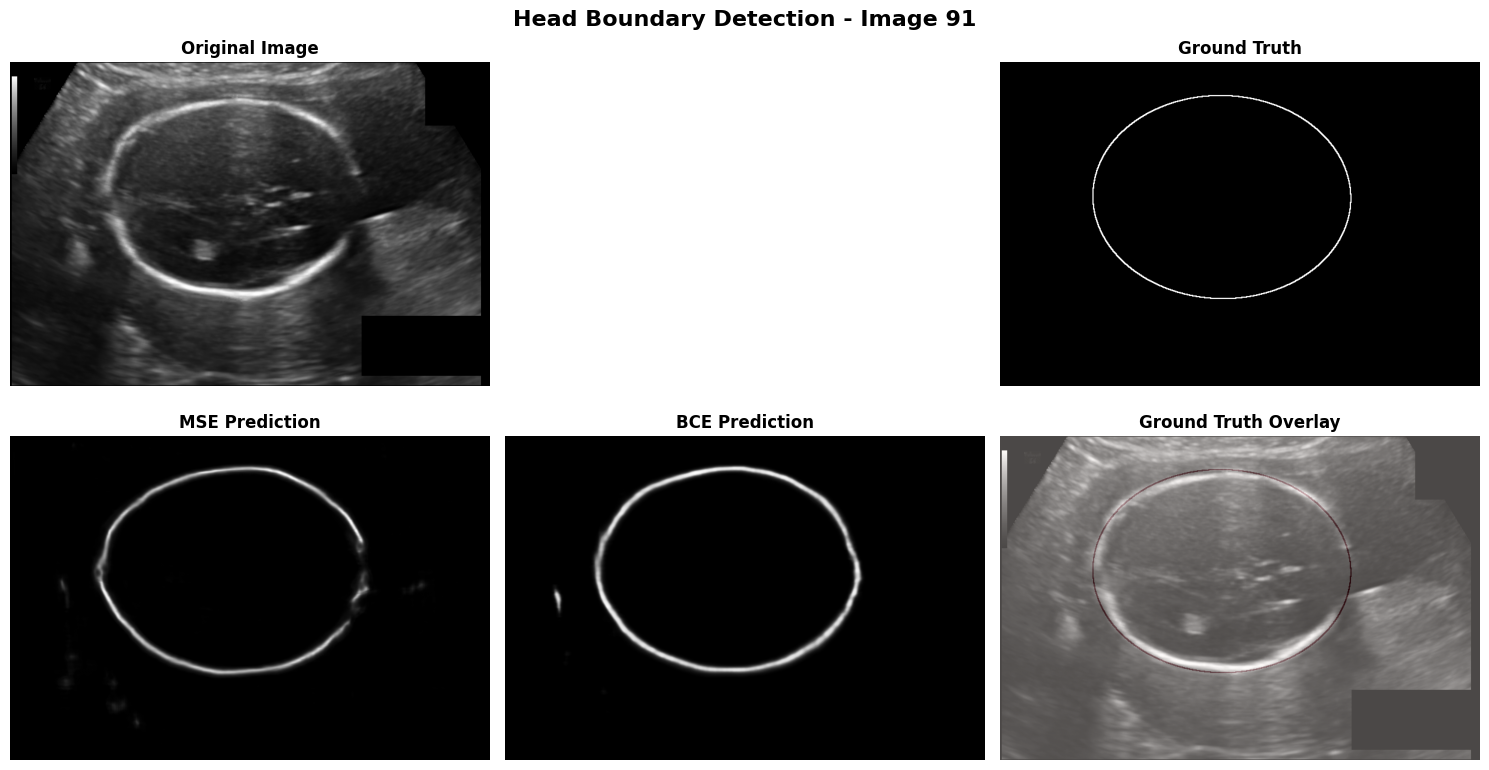

**Figure saved: figure91_head_boundary.png**


In [12]:
def get_test_sample(dataset, index):
    """Get a specific test sample"""
    return dataset[index]

def visualize_predictions(models_dict, image, mask, image_idx, save_name):
    """Visualize predictions from all models for a single image"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Original image and ground truth
    axes[0, 0].imshow(image.squeeze().cpu().numpy(), cmap='gray')
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
    axes[0, 2].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Predictions from each model
    loss_names = ['MSE', 'BCE']
    for idx, loss_name in enumerate(loss_names):
        model = models_dict[loss_name]
        model.eval()
        
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device))
            pred = pred.squeeze().cpu().numpy()
        
        axes[1, idx].imshow(pred, cmap='gray')
        axes[1, idx].set_title(f'{loss_name} Prediction', fontsize=12, fontweight='bold')
        axes[1, idx].axis('off')
    
    # Overlay comparison
    axes[1, 2].imshow(image.squeeze().cpu().numpy(), cmap='gray')
    axes[1, 2].imshow(mask.squeeze().cpu().numpy(), cmap='Reds', alpha=0.3)
    axes[1, 2].set_title('Ground Truth Overlay', fontsize=12, fontweight='bold')
    axes[1, 2].axis('off')
    
    plt.suptitle(f'Head Boundary Detection - Image {image_idx}', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.show()
    
    return save_name

test_indices = [1, 50, 90]
figure_numbers = [2, 51, 91]

saved_figures = []

for test_idx, fig_num in zip(test_indices, figure_numbers):
    print(f'\nGenerating Figure {fig_num}...')
    
    # Get the test sample
    image, mask = test_dataset.dataset[test_dataset.indices[test_idx]]
    
    # Create visualization
    save_name = f'figure{fig_num}_head_boundary.png'
    visualize_predictions(models_dict, image, mask, fig_num, save_name)
    saved_figures.append((fig_num, save_name))
    
    print(f'**Figure saved: {save_name}**')